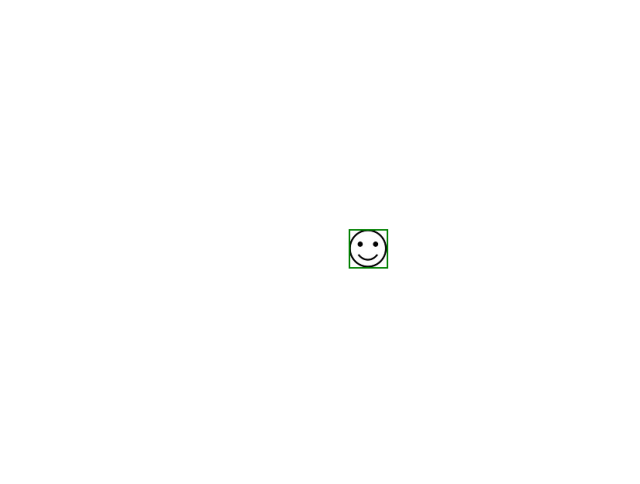

Smiling emoji detected at: (437, 284)


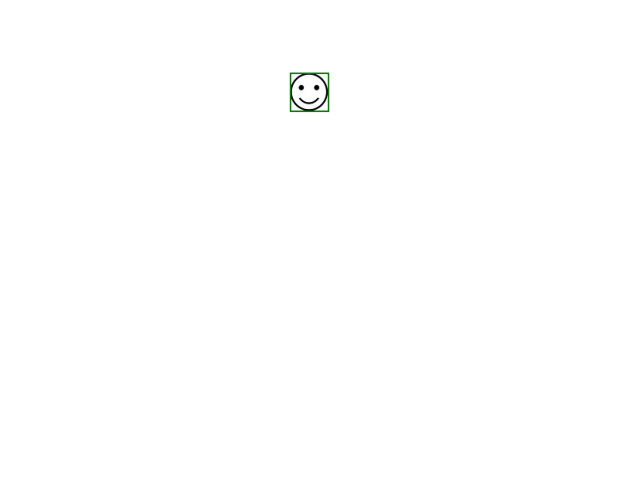

Smiling emoji detected at: (361, 82)


KeyboardInterrupt: 

In [99]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def mse(imageA, imageB):
    """Calculate Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

for i in range(101):
    # Load images using PIL
    try:
        image = Image.open(f"data/basic/dataset/emoji_{i}.jpg").convert("L")  # Convert to grayscale
    except:
        continue
    template = Image.open("data/basic/dataset/emoji_to_find.jpg").convert("L")

    # Convert images to NumPy arrays
    image_array = np.array(image)
    template_array = np.array(template)

    # Convert grayscale image to RGB for drawing
    image_rgb = image.convert("RGB")
    draw = ImageDraw.Draw(image_rgb)  # Enable drawing

    # Sliding window parameters
    window_size = 50
    step_size = 1
    threshold = 500  # Adjust this for matching accuracy

    match = None

    # Slide over the image
    for y in range(0, image_array.shape[0] - window_size, step_size):
        for x in range(0, image_array.shape[1] - window_size, step_size):
            # Extract window
            window = image_array[y:y+window_size, x:x+window_size]

            # Compare with template
            error = mse(window, template_array)
        
            # If MSE is low, it's a match
            if error < threshold:
                match = (x, y)
                draw.rectangle([x, y, x+window_size, y+window_size], outline="green", width=2)

    # Display the image with detected matches
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)  # Ensure correct color interpretation
    plt.axis("off")
    plt.show()

    # Print detected positions
    if match is not None:
        print(f"Smiling emoji detected at: {match}")
    else:
        print("Smiling emoji not found.")
    match = None


In [98]:
import cv2
import numpy as np
import os

# Folder containing emoji templates (each emoji type is a separate 50x50 jpg file)
emoji_types = ["happy", "sad", "crying", "surprised", "angry"]
emoji_templates = {emoji: cv2.imread(f"data/emojis/{emoji}.jpg", cv2.IMREAD_GRAYSCALE) for emoji in emoji_types}
# print(emoji_templates)

# Load the input image
image_name = "data/train/dataset/emoji_1.jpg"  # Change to the correct filename
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Create SIFT detector (or use ORB if OpenCV does not support SIFT)
sift = cv2.SIFT_create(nfeatures=1000)  # Use cv2.ORB_create() if SIFT is unavailable
# sift = cv2.ORB_create(nfeatures=100)

# Detect keypoints and descriptors for the input image
keypoints_img, descriptors_img = sift.detectAndCompute(image, None)

# Store detected emoji results
detected_emojis = []

# Match each emoji template
for emoji_name, template in emoji_templates.items():
    if template is None:
        print(f"Error loading template: {emoji_name}.jpg")
        continue  # Skip if template is missing

    # Detect keypoints and descriptors for the emoji template
    keypoints_tmpl, descriptors_tmpl = sift.detectAndCompute(template, None)

    if descriptors_tmpl is None:
        print(f"Skipping {emoji_name}: No descriptors found.")
        continue

    # Use FLANN-based matcher for SIFT
    index_params = dict(algorithm=1, trees=10)  # KDTree for SIFT
    search_params = dict(checks=100)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches
    matches = matcher.knnMatch(descriptors_tmpl, descriptors_img, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:  # Threshold for good matches
            good_matches.append(m)

    print(f"Emoji: {emoji_name} Matches: {len(good_matches)}")

    # If we have enough good matches, estimate emoji position
    if len(good_matches) > 3:  # Require at least 4 good matches (4 points needed for findHomography)
        src_pts = np.float32([keypoints_tmpl[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find transformation matrix using RANSAC
        # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
        
        # print(f"M: {M}")

        # if M is not None:
        #     # Get the center of the matched emoji
        #     mean_x = int(np.mean(dst_pts[:, 0, 0]))
        #     mean_y = int(np.mean(dst_pts[:, 0, 1]))

        #     detected_emojis.append((emoji_name, (mean_x, mean_y)))
        
        # Get the corner of the matched emoji
        mean_x = int(np.min(dst_pts[:, 0, 0]))
        mean_y = int(np.min(dst_pts[:, 0, 1]))

        detected_emojis.append((emoji_name, (mean_x, mean_y)))

print(f"Detected {len(detected_emojis)} emojis.")

# Print results
for emoji_name, (x, y) in detected_emojis:
    print(f"Picture: {image_name} Emoji: {emoji_name} Coordinates: ({x}, {y})")


Emoji: happy Matches: 1
Emoji: sad Matches: 2
Emoji: crying Matches: 11
Emoji: surprised Matches: 2
Emoji: angry Matches: 3
Detected 1 emojis.
Picture: data/train/dataset/emoji_1.jpg Emoji: crying Coordinates: (475, 263)


In [65]:
import cv2
import numpy as np

# Load emoji templates (each emoji type is a 50x50 jpg file)
emoji_types = ["happy", "sad", "crying", "surprised", "angry"]
emoji_templates = {emoji: cv2.imread(f"data/emojis/{emoji}.jpg", cv2.IMREAD_GRAYSCALE) for emoji in emoji_types}

# Load the input image
image_name = "data/train/dataset/emoji_813.jpg"  # Change to the correct filename
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Create SIFT detector (or ORB if SIFT is unavailable)
sift = cv2.SIFT_create(nfeatures=1000)

# Detect keypoints and descriptors for the input image
keypoints_img, descriptors_img = sift.detectAndCompute(image, None)

# Store detected emoji results
detected_regions = []  # Stores locations of all detected emoji keypoints

# Step 1: Detect possible emoji locations first (without classification)
for emoji_name, template in emoji_templates.items():
    if template is None:
        print(f"Error loading template: {emoji_name}.jpg")
        continue

    keypoints_tmpl, descriptors_tmpl = sift.detectAndCompute(template, None)

    if descriptors_tmpl is None:
        print(f"Skipping {emoji_name}: No descriptors found.")
        continue

    # Use FLANN-based matcher
    index_params = dict(algorithm=1, trees=10)  # KDTree for SIFT
    search_params = dict(checks=100)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches
    matches = matcher.knnMatch(descriptors_tmpl, descriptors_img, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    print(f"Emoji: {emoji_name} Matches: {len(good_matches)}")

    # If we have enough good matches, estimate emoji position
    if len(good_matches) > 3:
        dst_pts = np.float32([keypoints_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        for pt in dst_pts:
            x, y = int(pt[0][0]), int(pt[0][1])
            detected_regions.append((x, y))  # Store the location for classification

# Step 2: Cluster nearby keypoints to avoid duplicate detections
def cluster_keypoints(detected_regions, threshold=30):
    """
    Groups keypoints that are close together into clusters.
    """
    clusters = []
    for x, y in detected_regions:
        found_cluster = False
        for cluster in clusters:
            if np.linalg.norm(np.array(cluster) - np.array((x, y))) < threshold:
                found_cluster = True
                break
        if not found_cluster:
            clusters.append((x, y))
    return clusters

filtered_regions = cluster_keypoints(detected_regions)

# Step 3: Classify each detected region
detected_emojis = []

for (x, y) in filtered_regions:
    # Extract a 50x50 region around the detected point
    x1, y1 = max(0, x - 25), max(0, y - 25)
    x2, y2 = min(image.shape[1], x + 25), min(image.shape[0], y + 25)
    detected_emoji_region = image[y1:y2, x1:x2]

    # Compare with emoji templates using histogram similarity
    best_match = None
    best_score = -1

    for emoji_name, template in emoji_templates.items():
        resized_template = cv2.resize(template, (x2 - x1, y2 - y1))  # Resize to match detected region

        hist1 = cv2.calcHist([resized_template], [0], None, [256], [0, 256])
        hist2 = cv2.calcHist([detected_emoji_region], [0], None, [256], [0, 256])

        score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

        if score > best_score:
            best_score = score
            best_match = emoji_name

    detected_emojis.append((best_match, (x, y)))

print(f"Detected {len(detected_emojis)} emojis.")

# Print results
for emoji_name, (x, y) in detected_emojis:
    print(f"Picture: {image_name} Emoji: {emoji_name} Coordinates: ({x}, {y})")


Emoji: happy Matches: 0
Emoji: sad Matches: 2
Emoji: crying Matches: 2
Emoji: surprised Matches: 0
Emoji: angry Matches: 9
Detected 2 emojis.
Picture: data/train/dataset/emoji_813.jpg Emoji: happy Coordinates: (724, 205)
Picture: data/train/dataset/emoji_813.jpg Emoji: happy Coordinates: (743, 180)


In [80]:
import cv2
import numpy as np

# Load emoji templates (each emoji type is a separate 50x50 jpg file)
emoji_types = ["happy", "sad", "crying", "surprised", "angry"]
emoji_templates = {emoji: cv2.imread(f"data/emojis/{emoji}.jpg", cv2.IMREAD_GRAYSCALE) for emoji in emoji_types}

# Load the input image
image_name = "data/train/dataset/emoji_1115.jpg"  # Change to the correct filename
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Create SIFT detector
sift = cv2.SIFT_create(nfeatures=1000)

# Detect keypoints and descriptors for the input image
keypoints_img, descriptors_img = sift.detectAndCompute(image, None)

# Store detected emoji results
detected_regions = []

# Step 1: Detect potential emoji locations first (without classification)
for emoji_name, template in emoji_templates.items():
    if template is None:
        print(f"Error loading template: {emoji_name}.jpg")
        continue

    # Detect keypoints and descriptors for the emoji template
    keypoints_tmpl, descriptors_tmpl = sift.detectAndCompute(template, None)
    
    if descriptors_tmpl is None:
        print(f"Skipping {emoji_name}: No descriptors found.")
        continue

    # Use FLANN-based matcher
    index_params = dict(algorithm=1, trees=10)  # KDTree for SIFT
    search_params = dict(checks=100)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches
    matches = matcher.knnMatch(descriptors_tmpl, descriptors_img, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Threshold for good matches
            good_matches.append(m)

    print(f"Emoji: {emoji_name} Matches: {len(good_matches)}")

    # If we have enough good matches, estimate emoji position
    if len(good_matches) > 3:  # Require at least 3 good matches (4 points needed for findHomography)
        src_pts = np.float32([keypoints_tmpl[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Use RANSAC to estimate the transformation matrix (homography)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:
            # Get transformed corners of the matched emoji
            h, w = template.shape
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
            transformed_corners = cv2.perspectiveTransform(corners, M)

            # Get the bounding box for the emoji
            min_x = int(min(transformed_corners[:, 0, 0]))
            max_x = int(max(transformed_corners[:, 0, 0]))
            min_y = int(min(transformed_corners[:, 0, 1]))
            max_y = int(max(transformed_corners[:, 0, 1]))

            detected_regions.append((emoji_name, min_x, min_y, max_x, max_y))

# Step 2: Filter overlapping detections (cluster nearby detections)
def filter_overlapping_regions(detected_regions, min_distance=30):
    filtered = []
    for emoji_name, x1, y1, x2, y2 in detected_regions:
        if not any(
            abs(x1 - fx1) < min_distance and abs(y1 - fy1) < min_distance
            for _, fx1, fy1, _, _ in filtered
        ):
            filtered.append((emoji_name, x1, y1, x2, y2))
    return filtered

filtered_emojis = filter_overlapping_regions(detected_regions)

# Step 3: Print results
print(f"Detected {len(filtered_emojis)} emojis.")
for emoji_name, x1, y1, x2, y2 in filtered_emojis:
    print(f"Picture: {image_name} Emoji: {emoji_name} Coordinates: ({x1}, {y1})")


Emoji: happy Matches: 0
Emoji: sad Matches: 0
Emoji: crying Matches: 2
Emoji: surprised Matches: 0
Emoji: angry Matches: 3
Detected 0 emojis.


In [102]:
import cv2
import numpy as np

# Load emoji templates (each emoji type is a separate 50x50 jpg file)
emoji_types = ["happy", "sad", "crying", "surprised", "angry"]
emoji_templates = {emoji: cv2.imread(f"data/emojis/{emoji}.jpg", cv2.IMREAD_GRAYSCALE) for emoji in emoji_types}

# Load the input image
image_name = "data/train/dataset/emoji_474.jpg"  # Change to the correct filename
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Create SIFT detector
sift = cv2.SIFT_create(nfeatures=1000)

# Detect keypoints and descriptors for the input image
keypoints_img, descriptors_img = sift.detectAndCompute(image, None)

# Store detected emoji results
detected_regions = []

# Step 1: Detect potential emoji locations first (without classification)
for emoji_name, template in emoji_templates.items():
    if template is None:
        print(f"Error loading template: {emoji_name}.jpg")
        continue

    # Detect keypoints and descriptors for the emoji template
    keypoints_tmpl, descriptors_tmpl = sift.detectAndCompute(template, None)
    
    if descriptors_tmpl is None:
        print(f"Skipping {emoji_name}: No descriptors found.")
        continue

    # Use FLANN-based matcher
    index_params = dict(algorithm=1, trees=10)  # KDTree for SIFT
    search_params = dict(checks=100)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Find matches
    matches = matcher.knnMatch(descriptors_tmpl, descriptors_img, k=2)

    # Apply Lowe’s ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.9 * n.distance:  # Threshold for good matches (adjust for more robustness)
            good_matches.append(m)

    # print(f"Emoji: {emoji_name} Matches: {len(good_matches)}")

    # If we have enough good matches, proceed
    if len(good_matches) > 5:  # Require at least 5 good matches for better accuracy
        src_pts = np.float32([keypoints_tmpl[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Step 2: Use Homography (RANSAC) to find the transformation matrix
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  # 5.0 is the threshold for outlier rejection

        if M is not None:
            # Step 3: Apply the transformation to the template's corners to get the transformed bounding box
            h, w = template.shape
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
            transformed_corners = cv2.perspectiveTransform(corners, M)

            # Step 4: Get the bounding box of the transformed corners
            min_x = int(min(transformed_corners[:, 0, 0]))
            max_x = int(max(transformed_corners[:, 0, 0]))
            min_y = int(min(transformed_corners[:, 0, 1]))
            max_y = int(max(transformed_corners[:, 0, 1]))

            # Add the detected region to the list
            detected_regions.append((emoji_name, min_x, min_y, max_x, max_y))

# Step 5: Filter overlapping detections (cluster nearby detections)
def filter_overlapping_regions(detected_regions, min_distance=30):
    filtered = []
    for emoji_name, x1, y1, x2, y2 in detected_regions:
        if not any(
            abs(x1 - fx1) < min_distance and abs(y1 - fy1) < min_distance
            for _, fx1, fy1, _, _ in filtered
        ):
            filtered.append((emoji_name, x1, y1, x2, y2))
    return filtered

filtered_emojis = filter_overlapping_regions(detected_regions)

# Step 6: Print results
# print(f"Detected {len(filtered_emojis)} emojis.")
print(f"Picture: {image_name}")
for emoji_name, x1, y1, x2, y2 in filtered_emojis:
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
    print(f"Emoji: {emoji_name} Coordinates: ({x1}, {y1})")


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:521: error: (-215:Assertion failed) (size_t)knn <= index_->size() in function 'runKnnSearch_'


In [114]:
import cv2
import numpy as np

def implementation_main():
    # Load emoji templates (each emoji type is a separate 50x50 jpg file)
    emoji_types = ["happy", "sad", "crying", "surprised", "angry"]
    emoji_templates = {emoji: cv2.imread(f"data/emojis/{emoji}.jpg", cv2.IMREAD_GRAYSCALE) for emoji in emoji_types}
    
    # Create SIFT detector
    sift = cv2.SIFT_create(nfeatures=1000)
    
    for i in range(12):
        # Load the input image
        image_name = f"data/train/dataset/emoji_{i}.jpg"  # Change to the correct filename
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

        # Step 1: Thresholding or edge detection to find potential emoji areas
        _, thresholded = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)  # Inverse thresholding
        # Alternatively, you can use Canny edge detection
        # thresholded = cv2.Canny(image, 100, 200)

        # Step 2: Find contours (regions of interest that might contain emojis)
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(f"Found {len(contours)} contours in {image_name}: {contours}")

        detected_regions = []
        for contour in contours:
            # Step 3: Filter small contours (that might not be emojis)
            area = cv2.contourArea(contour)
            if area < 100:  # Minimum area threshold for emoji region
                continue

            # Get the bounding box around the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Extract the potential emoji region from the image
            roi = image[y:y+h, x:x+w]
            
            # Step 4: Compare the detected region with emoji templates using SIFT
            best_match = None
            best_match_score = float('inf')  # We want to minimize the distance
            
            for emoji_name, template in emoji_templates.items():
                if template is None:
                    continue
                
                # Resize template to match the size of the detected region (for better matching)
                resized_template = cv2.resize(template, (w, h))
                
                # Detect keypoints and descriptors for the detected region and template
                keypoints_img, descriptors_img = sift.detectAndCompute(roi, None)
                keypoints_tmpl, descriptors_tmpl = sift.detectAndCompute(resized_template, None)
                
                if descriptors_img is None or descriptors_tmpl is None:
                    continue
                
                # Use FLANN-based matcher
                index_params = dict(algorithm=1, trees=10)
                search_params = dict(checks=100)
                matcher = cv2.FlannBasedMatcher(index_params, search_params)
                
                # Find matches
                matches = matcher.knnMatch(descriptors_tmpl, descriptors_img, k=2)
                
                # Apply Lowe’s ratio test
                good_matches = [m for m, n in matches if m.distance < 0.9 * n.distance]
                
                # If good matches are found, compute the match score
                if len(good_matches) > 5:  # Require a minimum number of good matches
                    match_score = len(good_matches)
                    if match_score < best_match_score:
                        best_match_score = match_score
                        best_match = emoji_name
            
            if best_match is not None:
                # Add the detected region and the matched emoji to the list
                detected_regions.append((best_match, x, y, x+w, y+h))

        # Step 5: Filter overlapping detections (optional)
        def filter_overlapping_regions(detected_regions, min_distance=30):
            filtered = []
            for emoji_name, x1, y1, x2, y2 in detected_regions:
                if not any(
                    abs(x1 - fx1) < min_distance and abs(y1 - fy1) < min_distance
                    for _, fx1, fy1, _, _ in filtered
                ):
                    filtered.append((emoji_name, x1, y1, x2, y2))
            return filtered
        
        filtered_emojis = filter_overlapping_regions(detected_regions)

        # Step 6: Print results
        print(f"Picture: {image_name.split('/')[-1]}")
        for emoji_name, x1, y1, x2, y2 in filtered_emojis:
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            print(f"Emoji: {emoji_name} Coordinates: ({x1}, {y1})")

implementation_main()

Picture: emoji_0.jpg
Emoji: angry Coordinates: (436, 371)
Emoji: sad Coordinates: (605, 304)
Emoji: happy Coordinates: (490, 281)
Picture: emoji_1.jpg
Emoji: angry Coordinates: (462, 256)
Picture: emoji_2.jpg
Emoji: angry Coordinates: (231, 339)
Picture: emoji_3.jpg
Emoji: happy Coordinates: (136, 124)
Picture: emoji_4.jpg
Emoji: sad Coordinates: (704, 287)
Picture: emoji_5.jpg
Emoji: happy Coordinates: (609, 331)
Picture: emoji_6.jpg
Emoji: happy Coordinates: (441, 497)
Picture: emoji_7.jpg
Emoji: surprised Coordinates: (260, 394)
Picture: emoji_8.jpg
Emoji: crying Coordinates: (225, 342)
Picture: emoji_9.jpg
Emoji: angry Coordinates: (531, 284)
Picture: emoji_10.jpg
Emoji: angry Coordinates: (378, 87)
Picture: emoji_11.jpg
Emoji: happy Coordinates: (541, 88)
